$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\EE}{\mathbb{E}}$

In [1]:
%matplotlib inline
from ipywidgets import interactive
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import os.path

In [2]:
# Uncoment the pip command below if you are using Google Colab. 
# In case of errors, use the option --upgrade --force-reinstall

#!pip install git+https://github.com/Guillaume-Garrigos/invprob.git  # For Google Colab
import sys  # For local launch
sys.path.append('..')  # For local launch
import invprob.sparse as sparse
from invprob.optim import fb_lasso

In [3]:
np.random.seed(seed=74)  # Seed for np.random
dpi = 100  # Resolution for plotting (230 for small screen, 100 for large one)
plt.ion()

# Notes on Inverse Problems
(c) Guillaume Garrigos. This notebook is rendered as a static page on [nbviewer](https://nbviewer.jupyter.org/github/Guillaume-Garrigos/invprob/blob/master/notebook/lasso_2-noise_parameter_selection.ipynb), and as an interactive notebook on [Google Colab](https://colab.research.google.com/github/Guillaume-Garrigos/invprob/blob/master/notebook/lasso_2-noise_parameter_selection.ipynb)

## II. Sparse Regularisation with the L1 norm (LASSO) : noise and parameter selection

We still try to recover a ground truth signal $x_0\in \RR^N$, which is sparse, in the sense that it is the solution of the following optimisation problem

\begin{equation}\label{Eq:true problem}
\min\limits_{y = \Phi x} \ \Vert x \Vert_1 , \hspace{1cm} \text{ where } \Vert x \Vert_1 := \sum_{i=1}^N \vert x_i \vert.
\tag{$P_0$}
\end{equation}

But instead of being given the linear measurment $y$, we assume here that we are given a *noisy* data $\hat{y}$, such that $\Vert y - \hat y \Vert \leq \sigma$. 
In other words, $\hat y = \Phi x_0 + \varepsilon$, where $\Vert \varepsilon \Vert \leq \delta$.

### 1. Presentation of the problem

We define $\Phi$, $x_0$, $y$ and a unitary noisy vector $\varepsilon$.

In [4]:
# We start by defining the characteristics of the problem
data_size = 100
data_number = round(data_size / 2)
sparsity_level = 10

# We define the main components of our problem
Phi = np.random.randn(data_number, data_size)
x0 = np.sign(sparse.randn(data_size, 1, sparsity_level))
y = Phi@x0
noisy_vector = np.random.randn(data_number, 1)

Given a noisy measurement $\hat{y}$, we can try to find (approximatively) a solution of 

\begin{equation}
\min\limits_{\hat{y} = \Phi x} \ \Vert x \Vert_1
\tag{$\hat{P}_0$}
\end{equation}

by taking a small value of $\lambda$ and computing a solution $\hat x_\lambda$ of

\begin{equation}
\min\limits_{x \in \RR^N} \hat{f}_\lambda(x):= \Vert x \Vert_1 + \frac{1}{2 \lambda}\Vert \Phi x - \hat{y} \Vert^2.
\tag{$\hat{P}_\lambda$}
\end{equation}

We will do that by running an instance of the Forward-Backward algorithm introduced in the previous notebook.

In [5]:
noise_level = 1
reg_param = 0.1
iter_nb = 40000
x_reg, details = fb_lasso(Phi, y + noise_level*noisy_vector, reg_param, iter_nb, verbose=True)

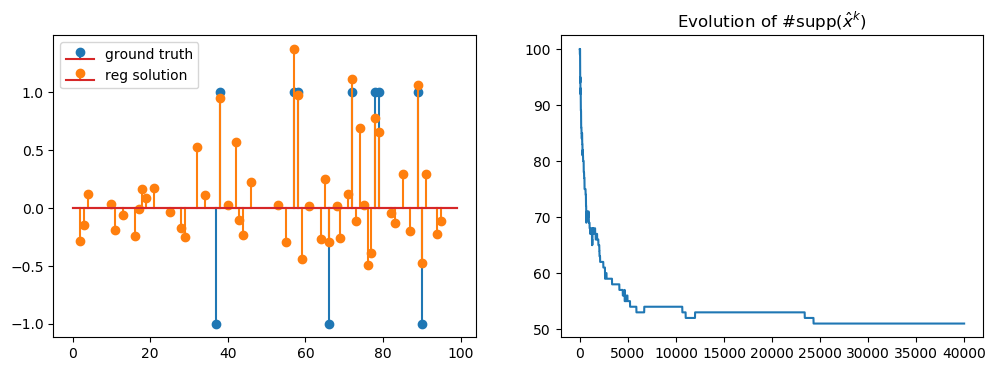

In [6]:
plt.figure(dpi=dpi, figsize=(12, 4))

plt.subplot(1, 2, 1)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_reg, "C1", "reg solution")

plt.subplot(1, 2, 2)
plt.title(r"Evolution of #supp$(\hat{x}^k)$")
plt.plot(details.get("iterate_support"))
plt.show()

We see that the algorithm converges towards a solution $\hat{x}_\lambda$ which is far from being close to $x_0$.
This is normal, since information has been lost about $x_0$ when noise contaminated the measurements.

Nevertheless, we are going to see that even though we have no hope to recover exactly $x_0$ in presence of noise, we can do *better* than what we just did.

### 2. The regularization path, again

Given noisy data, remember that the regularization path is 

$$\{x_\lambda \ | \ x_\lambda \text{ is a solution of } (P_\lambda), \lambda > 0 \}.$$

We saw in the noiseless case that an interesting feature of the regularization path is that $\hat{x}_\lambda \to \hat{x}_0$ when $\lambda \to 0$.
But this is useless here, since we are not interested at all in the solutions of the noisy problem $(\hat{P}_0)$.

Actually, the regularization path has an other interesting feature: it is *stable* with respect to noise on $y$.
To try to see this, we are going to compute the regularization path and try to vizualise it. 
A way to do so is to project these high-dimensional vectors onto a 2D plane.
Here, we select this 2D plane by extracting the two first eigenvectors of the covariance matrix of the path.

In [7]:
def compute_reg_path(Phi, y, reg_param_grid):
    ''' Given a matrix Phi and (noisy) data y, returns the regularision
    path: we compute solutions $x_\lambda$ of each problem $(P_\lambda)$
    for $\lambda$ being taken in the list reg_param_grid
    '''
    reg_path = np.empty((Phi.shape[1], 0), int)
    x_ini = np.zeros((Phi.shape[1], 1))
    for reg_param in reg_param_grid:
        ''' We choose the number of iterations to do depending on the reg_param.
        This is a completely custom choice, it seems to work quite well
        in practice.
        '''
        if reg_param < 0.1:
            iter_nb = 60000
        elif reg_param < 1:
            iter_nb = 4000
        elif reg_param < 10:
            iter_nb = 1000
        else:
            iter_nb = 200
        # We use a warm restart approach:
        # for each problem we use the solution of the previous problem
        # as a starting point
        x_reg = fb_lasso(Phi, y, reg_param, iter_nb, x_ini=x_ini)
        x_ini = x_reg
        reg_path = np.concatenate((reg_path, x_reg), axis=1)
    return reg_path

In [8]:
# We put a grid on the space of reg_param
# We taking it on a log scale and decreasing, between 10^2 and 10^-2
regp_number = 100
reg_param_grid = np.round(np.logspace(-2, 2, regp_number), 3)

# We compute the regularisation path for different values of noise:
# sigma = 10^-2, 10^-1, 10^0 and 0
# This can take some time!
reg_path_2 = compute_reg_path(Phi, y + 1e-2 * noisy_vector, reg_param_grid)
reg_path_1 = compute_reg_path(Phi, y + 1e-1 * noisy_vector, reg_param_grid)
reg_path_0 = compute_reg_path(Phi, y + 1e-0 * noisy_vector, reg_param_grid)
reg_path = compute_reg_path(Phi, y, reg_param_grid)

In [9]:
def get_pca_projector(data):
    ''' Given a set of data points (stored in columns of a 2D np.array)
    returns the projection matrix corresponding to the 2 more relevant
    directions
    '''
    centered_points = data - np.mean(data, axis=1).reshape(data.shape[0], 1)
    V = np.cov(centered_points)
    _, vectors = la.eig(V)
    return np.real(vectors[:, 0:2]).T


def scatter_reg_path(path, limit=None, title=None):
    ''' Given a 2D path, plots it using scatter
    '''
    cm = plt.cm.get_cmap('RdBu')
    if limit is not None:
        plt.scatter(limit[0, :], limit[1, :], c='r', marker='x', s=150)
    if title is not None:
        _ = plt.title(title)
    plt.plot(path[0, :], path[1, :], c='black', linewidth=0.5)
    fig = plt.scatter(path[0, :], path[1, :], c=range(path.shape[1]),
                      vmin=0, vmax=path.shape[1], s=35, cmap=cm)
    plt.colorbar(fig)

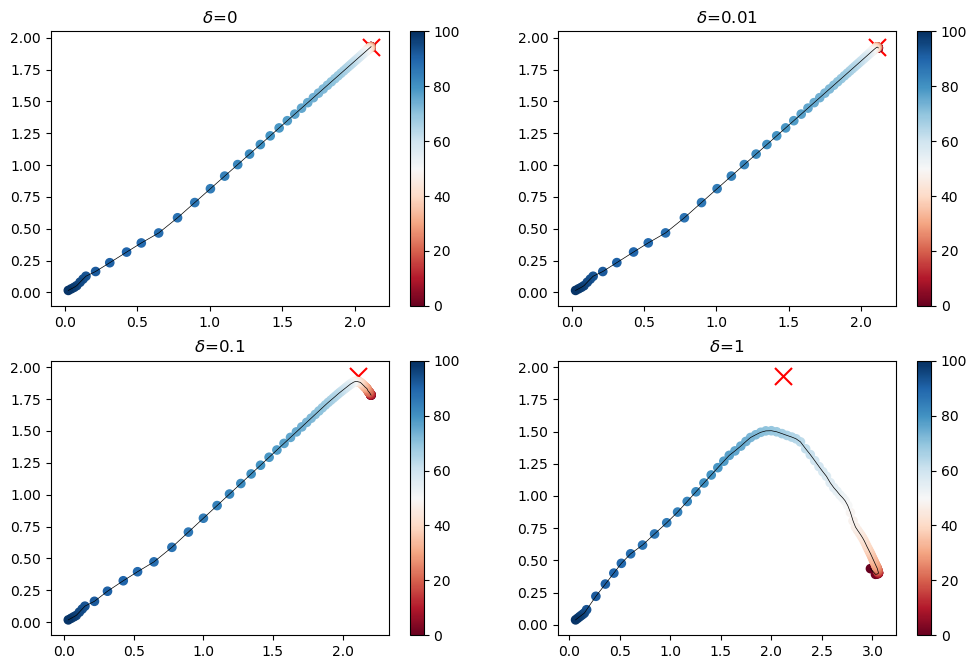

In [10]:
# We plot the (projected) regularisation paths and x0
P_svd = get_pca_projector(reg_path_0)

plt.figure(dpi=dpi, figsize=(12, 8))
plt.subplot(2, 2, 1)
scatter_reg_path(P_svd@reg_path, title="$\delta$=0", limit=P_svd@x0)
plt.subplot(2, 2, 2)
scatter_reg_path(P_svd@reg_path_2, title="$\delta$=0.01", limit=P_svd@x0)
plt.subplot(2, 2, 3)
scatter_reg_path(P_svd@reg_path_1, title="$\delta$=0.1", limit=P_svd@x0)
plt.subplot(2, 2, 4)
scatter_reg_path(P_svd@reg_path_0, title="$\delta$=1", limit=P_svd@x0)
plt.show()

We see that:
- in the noiseless case ($\delta=0$), the regularisation path goes from $x_{100}=0 $ to $x_{0.01} \sim x_0$.
- the more noise there is, the more the regularisation path tends to diverge from $x_0$ (in each case represented by a red cross). This is normal since it converges to $\hat{x}_0$.
- in presence of noise, the "extremity" of the path might be far from $x_0$ but other points on the path might be closer! So we should not take $\lambda \sim 0$, but instead choose it carefully so that $\hat{x}_\lambda$ is as close as possible from $x_0$.

In inverse problems, the step of choosing $\lambda$ is commonly referred as the *regularisation parameter selection* (or *hyperparameter selection* in the machine learning community).

### 3. Regularisation parameter selection (given the ground truth)

In this section we are interested in, given the regularisation path, finding the best possible regularised solution.
Here "best" is to be understand in the $L^2$ sense, meaning that we will look for the parameter $\lambda(\delta)$ minimizing $\Vert \hat{x}_\lambda - x_0 \Vert_2$.

In [11]:
def reg_param_selection(path, ground_truth):
    '''Given a regularization path and a ground truth,
    returns the best regularized solution (in L2 sense)
    '''
    path_length = path.shape[1]
    path_dimension = path.shape[0]
    reg_sol = path[:, 0, None]
    reg_param_index = 0
    for k in np.arange(path_length):
        if la.norm(ground_truth - path[:, k, None]) \
                < la.norm(ground_truth - reg_sol):
            reg_sol = path[:, k, None]
            reg_param_index = k
    return reg_sol, reg_param_index

In [12]:
# We compute the best parameter given the ground truth
reg_sol, reg_param_index = reg_param_selection(reg_path, x0)
reg_sol_2, reg_param_index_2 = reg_param_selection(reg_path_2, x0)
reg_sol_1, reg_param_index_1 = reg_param_selection(reg_path_1, x0)
reg_sol_0, reg_param_index_0 = reg_param_selection(reg_path_0, x0)

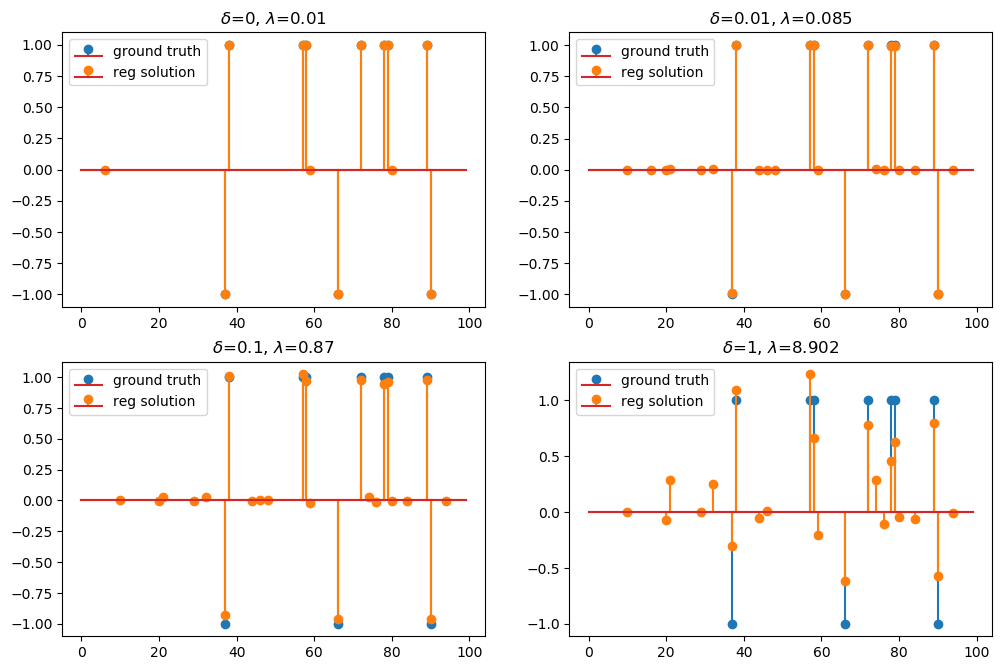

In [13]:
# We represent the selected solutions
_ = plt.figure(dpi=dpi, figsize=(12, 8))
plt.subplot(2, 2, 1)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(reg_sol, "C1", "reg solution")
plt.title(r"$\delta$=0, $\lambda$="+str(reg_param_grid[reg_param_index]))
plt.subplot(2, 2, 2)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(reg_sol_2, "C1", "reg solution")
plt.title(r"$\delta$=0.01, $\lambda$="+str(reg_param_grid[reg_param_index_2]))
plt.subplot(2, 2, 3)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(reg_sol_1, "C1", "reg solution")
plt.title(r"$\delta$=0.1, $\lambda$="+str(reg_param_grid[reg_param_index_1]))
plt.subplot(2, 2, 4)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(reg_sol_0, "C1", "reg solution")
plt.title(r"$\delta$=1, $\lambda$="+str(reg_param_grid[reg_param_index_0]))
plt.show()

In the case $\delta = 0.1$, the solution we obtain is *much* better than $\hat{x}_0$ that we computed at the begining!

We can visualise these selected solutions on a 2D plane as well:

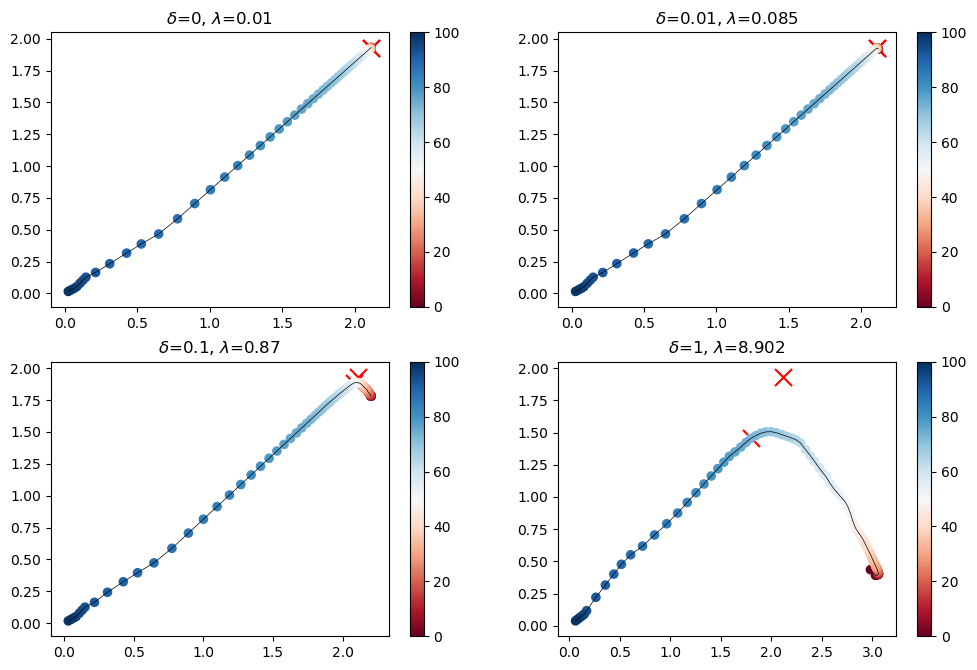

In [14]:
plt.figure(dpi=dpi, figsize=(12, 8))
plt.subplot(2, 2, 1)
scatter_reg_path(P_svd@reg_path,
                 title="$\delta$=0, $\lambda$="+str(reg_param_grid[reg_param_index]),
                 limit=np.concatenate((P_svd@x0, P_svd@reg_sol), axis=1))
plt.subplot(2, 2, 2)
scatter_reg_path(P_svd@reg_path_2,
                 title="$\delta$=0.01, $\lambda$="+str(reg_param_grid[reg_param_index_2]),
                 limit=np.concatenate((P_svd@x0, P_svd@reg_sol_2), axis=1))
plt.subplot(2, 2, 3)
scatter_reg_path(P_svd@reg_path_1,
                 title="$\delta$=0.1, $\lambda$="+str(reg_param_grid[reg_param_index_1]),
                 limit=np.concatenate((P_svd@x0, P_svd@reg_sol_1), axis=1))
plt.subplot(2, 2, 4)
scatter_reg_path(P_svd@reg_path_0,
                 title="$\delta$=1, $\lambda$="+str(reg_param_grid[reg_param_index_0]),
                 limit=np.concatenate((P_svd@x0, P_svd@reg_sol_0), axis=1))
plt.show()

### 4. Convergence rates (in the "inverse problem" sense)

We just saw that, by choosing carefully $\lambda$, we obtain regularised solutions $\hat{x}_\lambda$ which approximates quite well $x_0$. 
But how good this approximation can be? Of course, the more the data is corrupted by noise, the worse the approximation will be.
But we would like to know how much the error $\Vert \hat{x}_{\lambda(\delta)} - x_0 \Vert$ is affected by the level of noise $\delta$.

In general we try to obtain upper bounds of the form

$$ \Vert \hat{x}_{\lambda(\delta)} - x_0 \Vert = O(\delta^\alpha),$$

where $\alpha >0$ is a certain constant that we hope to be as large as possible.

In [15]:
# We import precomputed data (see a few blocks below for why we do that)
# Be careful, relative paths can be tricky depending on the platform ..
import_data = np.load('../output/L1_reg/reg_path_rates_examples.npy')
noise_level_grid = import_data[:, :, 0]
param_value = import_data[:, :, 1]
dist_to_truth = import_data[:, :, 2]

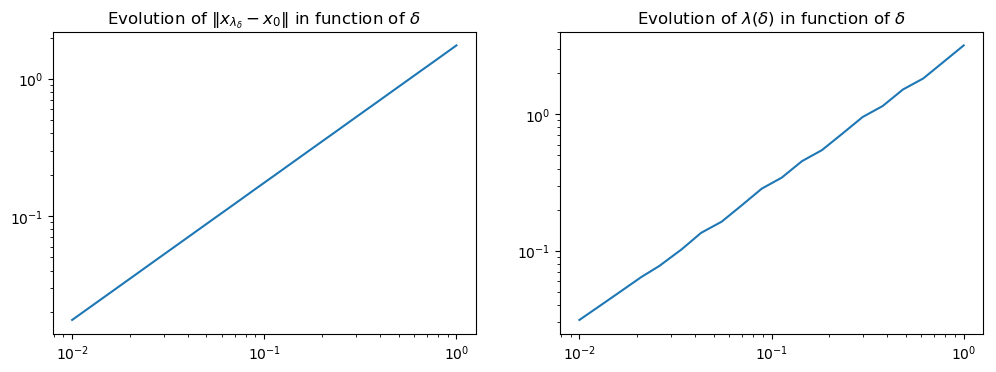

In [16]:
# We plot the rates
plt.figure(dpi=dpi, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title(r"Evolution of $\Vert x_{\lambda_\delta} - x_0 \Vert$ in function of $\delta$")
plt.loglog(noise_level_grid, dist_to_truth)
plt.subplot(1, 2, 2)
plt.title(r"Evolution of $\lambda(\delta)$ in function of $\delta$")
plt.loglog(noise_level_grid, param_value)
plt.show()

We can see from the graphs above that for $\lambda(\delta) \sim \delta$, we have $\Vert \hat{x}_{\lambda(\delta)} - x_0 \Vert \sim \delta$.

To produce the above figures, we computed 20 regularisation paths for 20 different levels of noise, after what we selected the best regularisation parameter. 
If you want to reproduce this experiment, with maybe different parameters, here is the code:

In [17]:
wanna_compute = False  # Just to prevent the computation of the next block by accident
batch_nb = 20  # number of paths we want to compute
noise_level_grid = np.round(np.logspace(-2, 0, batch_nb), 3).reshape(batch_nb, 1)

In [18]:
# This loop is *very* expensive
if wanna_compute:
    param_value = np.empty([batch_nb, 1])
    dist_to_truth = np.zeros((batch_nb, 1))
    for k in np.arange(batch_nb):
        print("Compute the regularisation path "+str(k+1)+" over "+str(batch_nb))
        reg_path_temp = compute_reg_path(Phi,
                                         y + noise_level_grid[k] * noisy_vector,
                                         reg_param_grid)
        reg_sol_temp, reg_param_index_temp = reg_param_selection(reg_path_temp, x0)
        param_value[k] = reg_param_grid[reg_param_index_temp]
        dist_to_truth[k] = la.norm(reg_sol_temp - x0)